In [3]:
import numpy as np
from hello.pid.lvpid import PIDController
from hello.pid.delay import seconds, minutes, hours, days, m2s, s2m, h2s, DelayBuffer, DelaySink
from hello.pid.gas_process import HeadspaceProcess, GasController
from hello.pid.do_simulation.doprocess import DOProcess, AIR_CNO

from hello.pid.do_simulation.options import SimOps, SimConfig
from hello.pid.picker import mk_picker
from hello.pid.do_simulation.sim_window import PIDSimFrame
from hello.pid.ui import TkQuitHack
from hello.pid.do_simulation.do_sim import do_sim_coroutine, do_sim
from matplotlib.ticker import MultipleLocator, FormatStrFormatter, FuncFormatter
%matplotlib
from matplotlib import pyplot as plt

Using matplotlib backend: TkAgg


### Copy this template to ensure all sim options are set correctly

In [4]:
ops = SimOps()
ops.o2_pid.p = 2
ops.o2_pid.i = 10
ops.o2_pid.d = 0
ops.o2_pid.amax = 100
ops.o2_pid.amin = 0
ops.o2_pid.beta = 1
ops.o2_pid.linearity = 1
ops.o2_pid.alpha = -1

ops.n2_pid.p = 5
ops.n2_pid.i = 5
ops.n2_pid.d = 0
ops.n2_pid.amax = 90
ops.n2_pid.amin = 0
ops.n2_pid.beta = 1
ops.n2_pid.linearity = 1
ops.n2_pid.alpha = -1

ops.mfcs.co2_max = 1
ops.mfcs.o2_max = 10
ops.mfcs.n2_max = 10
ops.mfcs.air_max = 10

ops.plots.xscale = 'auto'
ops.plots.xmin = 0
ops.plots.xmax = 72
ops.plots.xscale_factor = 3600

ops.delay = 0
ops.end = 10000
ops.initial_actual_cno = AIR_CNO
ops.initial_request_cno = (0.07, 0, 0)
ops.initial_pv = 90
ops.set_point = 40
ops.set_point_deadband = 1
ops.k_mult = 1.1
ops.k = DOProcess.default_k
ops.c = None
ops.dc = 0
ops.d2c = 0
ops.mode = "o2a"
ops.main_gas = 1.0
ops.reactor_size = 80
ops.reactor_volume = 55
ops.time_unit = hours
ops.max_iters = 3 * days

# Maximum value of c that O2 controller can sustain for a given k
ops.k*ops.k_mult*(100/20.95)*100

68.57279236276851

In [5]:
# O2 needs an extra padding space because the negative sign
# for N2 pgain doesn't count, i guesss
def fmt_float(f):
    if not f:
        return "0"
    f = str(f)
    if "." not in f:
        return f
    else:
        f = f.strip("0")
        if f[-1] == ".":
            f = f[:-1]
        if f[0] == ".":
            f = "0" + f
    return f
def get_text(ops):

    text = \
"""
O2: P=%3d  I=%5d  Initial PV: %3d  k: %.4f/hr (%sx Est.)
N2: P=%3d  I=%4d  Set Point:  %3d  c: %s%%/hr

 """ % (ops.o2_pid.p, ops.o2_pid.i,ops.initial_pv, ops.k*ops.k_mult, fmt_float(ops.k_mult),
        ops.n2_pid.p, ops.n2_pid.i, ops.set_point, fmt_float(ops.c))
    text = text.strip()
    return text

In [6]:
k_80L = 0.1306
k_15L = 0.19314
k_3L  = 0.24286

In [8]:
def np_unpack(l):
    return [np.array(data) for data in list(zip(*l))]

# 3L DO Tuning and Characterization

### 3L Basic Options

In [9]:
ops = SimOps()
ops.o2_pid.p = 2
ops.o2_pid.i = 40
ops.o2_pid.d = 0
ops.o2_pid.amax = 100
ops.o2_pid.amin = 0
ops.o2_pid.beta = 0
ops.o2_pid.linearity = 1
ops.o2_pid.alpha = -1

ops.n2_pid.p = -5
ops.n2_pid.i = 40
ops.n2_pid.d = 0
ops.n2_pid.amax = 90
ops.n2_pid.amin = 0
ops.n2_pid.beta = 0
ops.n2_pid.linearity = 1
ops.n2_pid.alpha = -1

ops.mfcs.co2_max = .1
ops.mfcs.o2_max = .5
ops.mfcs.n2_max = .5
ops.mfcs.air_max = .5

ops.plots.xscale = 'auto'
ops.plots.xmin = 0
ops.plots.xmax = 72
ops.plots.xscale_factor = 3600

ops.delay = 0
ops.end = 12*hours
ops.initial_actual_cno = AIR_CNO
ops.initial_request_cno = (0.07, 0, 0)
ops.initial_pv = 100
ops.set_point = 50
ops.set_point_deadband = 1
ops.k_mult = 1
ops.k = k_3L
ops.c = None
ops.dc = 0
ops.d2c = 0
ops.mode = "o2a"
ops.main_gas = 0.2
ops.reactor_size = 3
ops.reactor_volume = 2.5
ops.time_unit = hours
ops.max_iters = 3 * days

### 3L Graphs for Report

In [10]:
ax_list2 = []
fig = None

def axes():
    return ax_list2

def setup2(new=False):
    global fig, ax1, ax2, ax3, ax4, ax5, ax6
    global ax_list2
    
    if not plt.get_fignums() or new or not fig:
        fig = plt.figure()
        ax1 = fig.add_subplot(1,1,1)
        #ax2 = fig.add_subplot(2,1,2)
        ax2 = ax1.twinx()
        ax_list2 = [ax1, ax2]
        for a in axes():
            b = a.get_position()
            a.set_position([b.x0, b.y0+.1, b.width*.95, b.height*.9])
            a.grid()
    else:
        for a in axes():
            a.clear()
            a.grid()
        for t in fig.texts:
            t.remove()
    
    
    global colors, color
    colors = [
        "blue",
        "red",
        "green",
        "cyan",
        "purple",
        "orange",
        "black"
    ]

    import itertools
    color = itertools.cycle(colors).__next__
    
def test2(ops):
    d1, d2, d3 = do_sim(ops)
    x, pv, _, _, n2, o2, *_, o2a = np_unpack(d1)
    return x,pv, n2, o2, o2a*100/0.21

def _p1(ax, x, y, color, label, ylabel=None):
    ax.plot(x,y, color=color, label=label)
    if ylabel:
        ax.set_ylabel(ylabel)

def plot2(x, pv, n2, o2, o2a):
    c = color()
    _p1(ax1, x, pv, "blue", "pv", "DO (%)")
    _p1(ax2, x, o2, "green", "O2", "Gas Flow (%)")
    _p1(ax2, x, n2, "red", "N2")
    #_p1(ax3, x, pv, "blue", "pv", "DO (%)")
    #_p1(ax3, x, o2a, "red", "hs")
    
    ax1.axhline(y=ops.set_point, ls="--", color="black")
    ax1.axhline(y=ops.set_point-ops.set_point_deadband, ls="--", color="black", lw=0.5)
    ax1.axhline(y=ops.set_point+ops.set_point_deadband, ls="--", color="black", lw=0.5)
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%d%%"))
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "%d%%"%(y*100)))
    
    h = []
    l = []
    for a in axes():
        a.xaxis.set_major_locator(MultipleLocator(1))
        h_, l_ = a.get_legend_handles_labels()
        h.extend(h_)
        l.extend(l_)
    ax1.legend(h, l, loc="center", ncol=3, bbox_to_anchor=(0.5, -.18))
    
    ax1.set_xlabel("Time (hr)")
    
    fig.canvas.flush_events()
    fig.canvas.draw()
    
def finish2():
    for a in axes():
        if a.legend_:
            mk_picker(fig, a)
    
def run2(ops):
    x, pv, n2, o2, o2a = test2(ops)
    plot2(x, pv, n2, o2, o2a)
    finish2()

#### Export figures for report

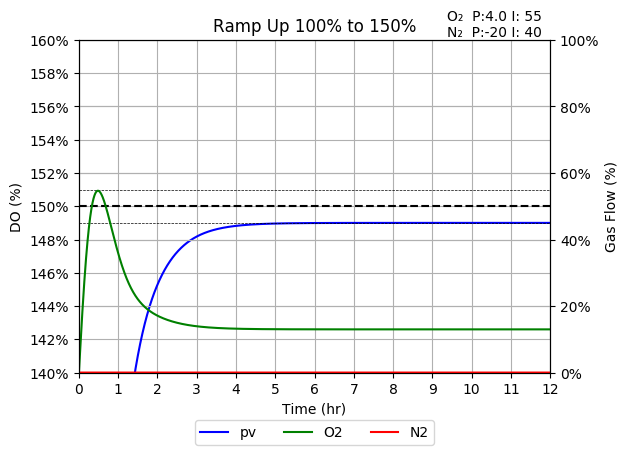

In [21]:
setup2()
ops.initial_request_cno = (0, 0, 0)
ops.initial_actual_cno = (0.0004, .78, .21)
ops.set_point = 150
ops.initial_pv = 100
ops.end = 12*hours

# Slower
ops.o2_pid.p = o2p = 4
ops.o2_pid.i = o2i = 55
ops.n2_pid.p = n2p = -20
ops.n2_pid.i = n2i = 40

ops.k_mult = 1
run2(ops)
ax1.set_xlim(0, 12)
ax1.set_ylim(140, 160)
a,b = ax2.set_ylim()
ax1.yaxis.set_major_locator(MultipleLocator(2))
ax2.set_ylim(0, 1)
ax1.set_title("Ramp Up 100% to 150%")
ax1.text(.7, .91, "O\u2082  P:%.1f I:%3d\nN\u2082  P:%3d I:%3d"%(o2p, o2i, n2p, n2i), transform=fig.transFigure)
path = 'C:\\PBSCloudStation\\(2) R&D-Product Engineering\\Software Development\\3.0 Project\\Phase 2 Working Copy\\IE00005 PID Tuning\\IE00005-06 DO\\Raw Data'
fig.savefig(path+"\\3L ramp up new 170728.png")
fig

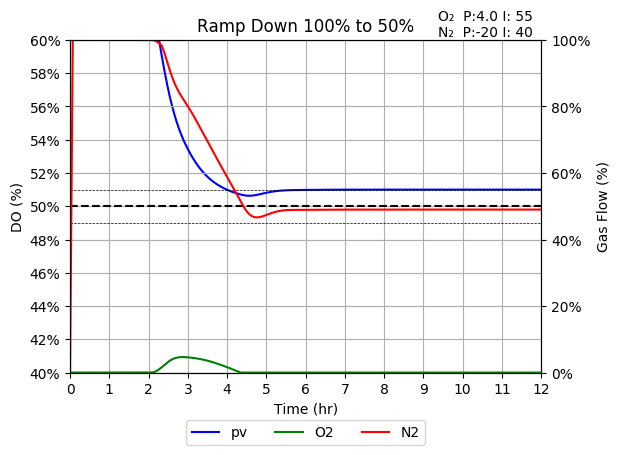

In [23]:
setup2()
ops.set_point = 50
ops.initial_pv = 100
ops.initial_request_cno = (0, 0, 0)
ops.initial_actual_cno = (0.0004, .78, .21)

# Slower
ops.o2_pid.p = o2p = 4
ops.o2_pid.i = o2i = 55
ops.n2_pid.p = n2p = -20
ops.n2_pid.i = n2i = 40
ops.n2_pid.amax = 100

ops.k_mult = 1
run2(ops)
ax1.set_xlim(0, 12)
ax1.set_ylim(40, 60)
ax2.set_ylim(0, 1)
ax1.yaxis.set_major_locator(MultipleLocator(2))
ax1.set_title("Ramp Down 100% to 50%")
ax1.text(.7, .91, "O\u2082  P:%.1f I:%3d\nN\u2082  P:%3d I:%3d"%(o2p, o2i, n2p, n2i), transform=fig.transFigure)
path = 'C:\\PBSCloudStation\\(2) R&D-Product Engineering\\Software Development\\3.0 Project\\Phase 2 Working Copy\\IE00005 PID Tuning\\IE00005-06 DO\\Raw Data'
fig.savefig(path+"\\3L ramp down new 170728.png")
fig

#### More tuning.....

In [65]:
def rampup(ops, x, y):
    setup2(True)
    ops.set_point = 150
    ops.initial_pv = 100
    run2(ops)
    ax1.set_xlim(0, 12)
    ax1.set_ylim(140, 160)
    a,b = ax2.set_ylim()
    ax2.set_ylim(0, b)
    ax1.set_title("Ramp Up: Gradual")
    w=fig.canvas._tkcanvas.master
    set_win_sz(w, x, y)
    
def set_win_sz(win, x,y):
    w, h = 565,433
    w*= 0.8
    h *=0.8
    win.geometry('%dx%d+%d+%d'%(w, h, x,y))
    
def rampdown(ops, x, y):
    setup2(True)
    ops.set_point = 50
    ops.initial_pv = 100
    run2(ops)
    ax1.set_xlim(0, 12)
    ax1.set_ylim(40, 60)
    ax2.set_ylim(0, 1)
    ax1.set_title("Ramp Down: Gradual")
    w=fig.canvas._tkcanvas.master
    set_win_sz(w, x, y)
    
def rampup2(ops):
    ops.set_point = 150
    ops.initial_pv = 100
    return test2(ops)
    
def rampdown2(ops):
    ops.set_point = 50
    ops.initial_pv = 100
    return test2(ops)
    
def run3(ops):
    x, pv, n2, o2, o2a = test2(ops)
    #plot2(x, pv, n2, o2, o2a)
    #finish2()
    return x, pv, n2, o2, o2a

def plot3(x, pv, n2, o2, o2a):
    c = color()
    _p1(ax1, x, pv, "blue", "pv", "DO (%)")
    _p1(ax2, x, o2, "green", "O2", "Gas Flow (%)")
    _p1(ax2, x, n2, "red", "N2")
    #_p1(ax3, x, pv, "blue", "pv", "DO (%)")
    #_p1(ax3, x, o2a, "red", "hs")
    
    ax1.axhline(y=ops.set_point, ls="--", color="black")
    ax1.axhline(y=ops.set_point-ops.set_point_deadband, ls="--", color="black", lw=0.5)
    ax1.axhline(y=ops.set_point+ops.set_point_deadband, ls="--", color="black", lw=0.5)
    ax1.yaxis.set_major_formatter(FormatStrFormatter("%d%%"))
    ax2.yaxis.set_major_formatter(FuncFormatter(lambda y, _: "%d%%"%(y*100)))
    
    h = []
    l = []
    for a in axes():
        a.xaxis.set_major_locator(MultipleLocator(1))
        h_, l_ = a.get_legend_handles_labels()
        h.extend(h_)
        l.extend(l_)
    ax1.legend(h, l, loc="center", ncol=3, bbox_to_anchor=(0.5, -.18))
    
    ax1.set_xlabel("Time (hr)")
    
    fig.canvas.flush_events()
    fig.canvas.draw()

In [45]:
# Balanced?
for i in range(100): plt.close()
ops.o2_pid.p = 4
ops.o2_pid.i = 70
ops.n2_pid.p = -5
ops.n2_pid.i = 50

rampup(ops, 1932, 0)
rampdown(ops, 2502, 0)

ops.o2_pid.p = 4
ops.o2_pid.i = 60
ops.n2_pid.p = -5
ops.n2_pid.i = 50

rampup(ops, 1932, 500)
rampdown(ops, 2502, 500)

In [17]:
def pid_iter():
    def lr(a,b, s=1):
        return list(range(a,b+s,s))
    p  = lr(1, 10) + lr(12, 20, 2)
    i = lr(40, 120, 5)
    for o2p in p:
        for n2p in p:
            n2p = -n2p
            for o2i in i:
                for n2i in i:
                    yield o2p, n2p, o2i, n2i

In [46]:
def getscore(n2, o2_2, pv, pv2):
    pv1t = 4*hours
    pv2t = 5*hours
    pv_where1 = pv[pv1t:]
    pv1_passed = np.any(np.abs(149 - pv[:pv1t]) < 1)
    pv_where2 = pv2[pv2t:]
    pv2_passed = np.any(np.abs(51 - pv2[:pv2t]) < 1)
    if not (pv1_passed and pv2_passed):
        return -1
    score = n2.sum()**2/len(n2) + o2_2.sum()**2/len(o2_2) + (np.abs(149-pv_where1).sum()/len(pv_where1) + np.abs(51-pv_where2).sum()/len(pv_where2))*10
    return score

In [47]:
o = "OVERRIDE"
if 'bdata' in globals() and bdata:
    r = input("Input %s to continue data reset: "%o)
else:
    r = o
    
if r == o:
    print("Resetting data!")
    best = None
    nbest = 0
    bdata = {}
    bdata2 = {}

Input OVERRIDE to continue data reset: OVERRIDE
Resetting data!


In [48]:
ops.end=12*hours
for i, params in enumerate(pid_iter()):
    o2p, n2p, o2i, n2i = params
    ops.o2_pid.p = o2p
    ops.o2_pid.i = o2i
    ops.n2_pid.p = n2p
    ops.n2_pid.i = n2i
    print("\rTesting %d %d %d %d           "%(o2p, n2p, o2i, n2i), end="")
    x, pv, n2, o2, o2a = rampup2(ops)
    x2, pv2, n2_2, o2_2, o2a_2 = rampdown2(ops)
    score = getscore(n2, o2_2, pv, pv2)
    if best is None or score < best and score >= 0:
        nbest += 1
        best = score
        print("New Best: %.1f"%best)
    bdata[params] = score
    bdata2[i] = params


Testing 1 -1 40 40           New Best: 525.1
Testing 1 -1 45 40            New Best: 351.6
Testing 1 -1 50 40            New Best: 240.4
Testing 1 -1 55 40            New Best: 172.7
Testing 1 -1 60 40            New Best: 134.6
Testing 1 -1 65 40            New Best: 115.1
Testing 1 -1 70 40            New Best: 106.8
Testing 1 -1 75 40            New Best: 105.4
Testing 1 -1 75 60           New Best: 102.7
Testing 1 -1 80 60            New Best: 94.7
Testing 1 -1 85 60            New Best: 92.7
Testing 1 -2 70 40             New Best: 72.3
Testing 1 -2 75 40            New Best: 63.9
Testing 1 -3 70 40             New Best: 62.5
Testing 1 -3 75 40            New Best: 46.2
Testing 1 -3 80 40            New Best: 43.1
Testing 1 -4 75 40             New Best: 39.3
Testing 1 -4 80 40            New Best: 33.2
Testing 1 -5 80 40             New Best: 28.1
Testing 1 -6 80 40             New Best: 25.1
Testing 1 -6 85 40            New Best: 24.9
Testing 1 -6 85 45           New Best: 24.8

In [52]:
import pickle
with open("do_sim_save", 'wb') as f:
    ob = (bdata, bdata2)
    pickle.dump(ob, f)

In [56]:
l = [p for p in bdata.items() if p[1] >=0]

In [57]:
l.sort(key=lambda p: p[1])

In [67]:
top10 = l[:10]
top10

[((4, -20, 55, 40), 0.46240616196923673),
 ((3, -20, 60, 45), 0.5122142763641816),
 ((4, -18, 55, 40), 0.58569785756434622),
 ((20, -20, 50, 40), 0.59332176237160184),
 ((20, -18, 50, 40), 0.62364643771723771),
 ((5, -20, 55, 40), 0.6548185909670633),
 ((3, -18, 60, 45), 0.65577168669896491),
 ((18, -20, 50, 40), 0.67417982372886365),
 ((3, -20, 65, 50), 0.67815996670622714),
 ((18, -18, 50, 40), 0.68645657169181595)]

In [66]:
i=0
[plt.close() for i in range(20)]
for (op, n2p, oi, ni), s in top10:
    ops.o2_pid.p = op
    ops.o2_pid.i = oi
    ops.n2_pid.p = n2p
    ops.n2_pid.i = ni

    rampup(ops, 100*i, 0)
    ax1.set_title("Ramp Up: %.3f"%s)
    rampdown(ops, 100*i, 400)
    ax1.set_title("Ramp Down: %.3f"%s)
    
    i += 1

In [ ]:
mk_test(4, -20, 55, 40)
mk_test(20, -20, 50, 40)
mk_test(3, -20, 60, 45)